# Rate Equation
## Objective
1. Define equation
2. Solve equation
3. Compute model and signal

```{note}
In this example, we only deal with gaussian and cauchy irf with same fwhm
```

In [1]:
import sys
sys.path.append('C:/Users/Reddy/Desktop/TRXASprefitpack/src')

In [2]:
# import needed module
import numpy as np
import matplotlib.pyplot as plt
import TRXASprefitpack
from TRXASprefitpack import solve_model, compute_model, rate_eq_conv 
plt.rcParams["figure.figsize"] = (14,10)

## Version information

In [3]:
print(TRXASprefitpack.__version__)

0.5.0


## basic information of functions

In [4]:
help(solve_model)

Help on function solve_model in module TRXASprefitpack.mathfun.rate_eq:

solve_model(equation: numpy.ndarray, y0: numpy.ndarray) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]
    Solve system of first order rate equation
    
    Args:
      equation: matrix corresponding to model
      y0: initial condition
    
    Returns:
       1. eigenvalues of equation
       2. eigenvectors for equation
       3. coefficient where y0 = Vc



In [5]:
help(compute_model)

Help on function compute_model in module TRXASprefitpack.mathfun.rate_eq:

compute_model(t: numpy.ndarray, eigval: numpy.ndarray, V: numpy.ndarray, c: numpy.ndarray) -> numpy.ndarray
    Compute solution of the system of rate equations solved by solve_model
    Note: eigval, V, c should be obtained from solve_model
    
    Args:
     t: time
     eigval: eigenvalue for equation
     V: eigenvectors for equation
     c: coefficient
    
    Returns:
      solution of rate equation
    
    Note:
      eigval, V, c should be obtained from solve_model.



In [6]:
help(rate_eq_conv)

Help on function rate_eq_conv in module TRXASprefitpack.mathfun.exp_decay_fit:

rate_eq_conv(t: numpy.ndarray, fwhm: Union[float, numpy.ndarray], abs: numpy.ndarray, eigval: numpy.ndarray, V: numpy.ndarray, c: numpy.ndarray, irf: Optional[str] = 'g', eta: Optional[float] = None) -> numpy.ndarray
    Constructs signal model rate equation with
    instrumental response function
    Supported instrumental response function are
    
    irf
      * g: gaussian distribution
      * c: cauchy distribution
      * pv: pseudo voigt profile
    
    Args:
       t: time
       fwhm: full width at half maximum of instrumental response function
       abs: coefficient for each excited state
       eigval: eigenvalue of rate equation matrix 
       V: eigenvector of rate equation matrix 
       c: coefficient to match initial condition of rate equation
       irf: shape of instrumental
            response function [default: g]
    
              * 'g': normalized gaussian distribution,
          

## Define equation

```{note}
In pump-probe time resolved spectroscopy, 
the concentration of ground state is not much important.
Only, the concentration of excited species are matter.
```

Consider model
```{code-block} python
'''
    k1     k2
A  ---> B ---> GS
y1: A
y2: B
y3: GS
'''
```

with initial condition 
\begin{equation*}
y(t) = \begin{cases}
(0, 0, 1) & \text{if $t < 0$}, \\
(1, 0, 0) & \text{if $t=0$}.
\end{cases}
\end{equation*}

Then what we need to solve is

\begin{equation*}
y'(t) = \begin{cases}
(0, 0, 0) & \text{if $t < 0$}, \\
Ay(t) & \text{if $t \geq 0$}
\end{cases}
\end{equation*}

with $y(0)=y_0$.

Where $A$ is

\begin{equation*}
A = \begin{pmatrix}
-k_1 & 0 & 0 \\
k_1 & -k_2 & 0 \\
0 & k_2 & 0
\end{pmatrix}
\end{equation*}


In [7]:
# set lifetime tau1 = 50 ps, tau2 = 1 ns
# set fwhm of IRF = 10 ps

tau1 = 50
tau2 = 1000
fwhm = 10

# initial condition
y0 = np.array([1, 0, 0])

# set time range (mixed step)
t_neg = np.arange(-2000, -100, 100)
t_short = np.arange(-100,200,5)
t_pos = np.arange(200,5000,100)
t = np.hstack((t_neg, t_short, t_pos))

# Define equation
equation = np.array([[-1/tau1, 0, 0],
                    [1/tau1, -1/tau2, 0],
                    [0, 1/tau2, 0]])

# Solve equation
eigval, V, c = solve_model(equation, y0)

In [8]:
# Now compute model
y = compute_model(t, eigval, V, c)


# since, y_1 + y_2 + y_3 = 1 for all t,
# y3 = 1 - (y_1+y_2)

y[-1, :] = 1 - (y[0, :] + y[1, :])

## plot model
1. short range

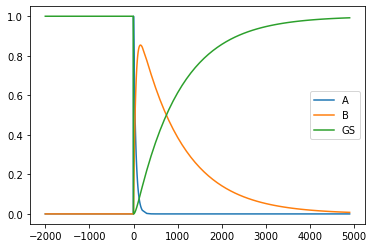

In [9]:
plt.plot(t, y[0, :], label='A')
plt.plot(t, y[1, :], label='B')
plt.plot(t, y[2, :], label='GS')
plt.legend()
plt.show()

## Compute Signal 
Difference absorption coefficient of ground state is 0
Now assume the difference absorption coefficient of A state is -0.5 and B state is 1

In [10]:
# time zero
t0_1 = -20 # ps
t0_2 = -15 # ps
t0_3 = -10 # ps
t0_4 = -25 # ps
# prefix
prefix_gau = 'example_tscan_gau'
prefix_cauchy = 'example_tscan_cauchy'

In [11]:
diff_abs = [-0.5, # A state
            1, # B state
            0, # ground state
           ]
err_gau_1 = np.random.normal(scale=0.05, size=t.size)
y_gau_1 = rate_eq_conv(t-t0_1, fwhm, diff_abs, eigval, V, c, irf = 'g')+err_gau_1
err_cauchy_1 = np.random.normal(scale=0.05, size=t.size)
y_cauchy_1 = rate_eq_conv(t-t0_1, fwhm, diff_abs, eigval, V, c, irf = 'c')+err_cauchy_1

## Plot signal

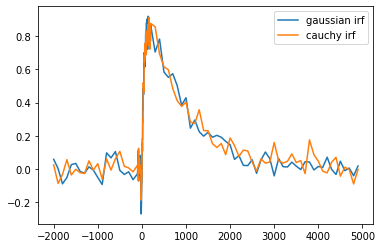

In [12]:
plt.plot(t, y_gau_1, label='gaussian irf')
plt.plot(t, y_cauchy_1, label='cauchy irf')
plt.legend()
plt.show()

## Compute Signal -2-
Difference absorption coefficient of ground state is 0
Now assume the difference absorption coefficient of A state is 0.5 and B state is 1

In [13]:
diff_abs = [0.5, # A state
            1, # B state
            0, # ground state
           ]
err_gau_2 = np.random.normal(scale=0.05, size=t.size)
y_gau_2 = rate_eq_conv(t-t0_2, fwhm, diff_abs, eigval, V, c, irf = 'g')+err_gau_2
err_cauchy_2 = np.random.normal(scale=0.05, size=t.size)
y_cauchy_2 = rate_eq_conv(t-t0_2, fwhm, diff_abs, eigval, V, c, irf = 'c')+err_cauchy_2

## Plot signal -2-

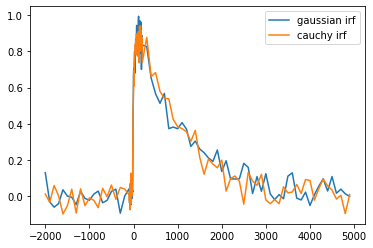

In [14]:
plt.plot(t, y_gau_2, label='gaussian irf')
plt.plot(t, y_cauchy_2, label='cauchy irf')
plt.legend()
plt.show()

## Compute Signal -3-
Difference absorption coefficient of ground state is 0
Now assume the difference absorption coefficient of A state is 1 and B state is 0.5

In [15]:
diff_abs = [1, # A state
            0.5, # B state
            0, # ground state
           ]
err_gau_3 = np.random.normal(scale=0.05, size=t.size)
y_gau_3 = rate_eq_conv(t-t0_3, fwhm, diff_abs, eigval, V, c, irf = 'g')+err_gau_3
err_cauchy_3 = np.random.normal(scale=0.05, size=t.size)
y_cauchy_3 = rate_eq_conv(t-t0_3, fwhm, diff_abs, eigval, V, c, irf = 'c')+err_cauchy_3

## Plot signal -3-

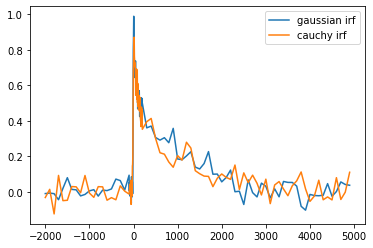

In [16]:
plt.plot(t, y_gau_3, label='gaussian irf')
plt.plot(t, y_cauchy_3, label='cauchy irf')
plt.legend()
plt.show()

## Compute Signal -4-
Difference absorption coefficient of ground state is 0
Now assume the difference absorption coefficient of A state is 1 and B state is 1

In [17]:
diff_abs = [1, # A state
            1, # B state
            0, # ground state
           ]
err_gau_4 = np.random.normal(scale=0.05, size=t.size)
y_gau_4 = rate_eq_conv(t-t0_4, fwhm, diff_abs, eigval, V, c, irf = 'g')+err_gau_4
err_cauchy_4 = np.random.normal(scale=0.05, size=t.size)
y_cauchy_4 = rate_eq_conv(t-t0_4, fwhm, diff_abs, eigval, V, c, irf = 'c')+err_cauchy_4

## Plot signal -4-

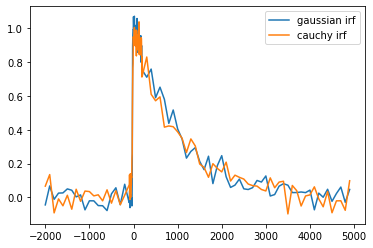

In [18]:
plt.plot(t, y_gau_4, label='gaussian irf')
plt.plot(t, y_cauchy_4, label='cauchy irf')
plt.legend()
plt.show()

In [19]:
# Generate model experimental code 
tscan_gau_1 = np.vstack((t, y_gau_1, err_gau_1))
tscan_gau_2 = np.vstack((t, y_gau_2, err_gau_2))
tscan_gau_3 = np.vstack((t, y_gau_3, err_gau_3))
tscan_gau_4 = np.vstack((t, y_gau_4, err_gau_4))
tscan_cauchy_1 = np.vstack((t, y_cauchy_1, err_cauchy_1))
tscan_cauchy_2 = np.vstack((t, y_cauchy_2, err_cauchy_2))
tscan_cauchy_3 = np.vstack((t, y_cauchy_3, err_cauchy_3))
tscan_cauchy_4 = np.vstack((t, y_cauchy_4, err_cauchy_4))

In [20]:
np.savetxt(prefix_gau+'_1.txt', tscan_gau_1)
np.savetxt(prefix_gau+'_2.txt', tscan_gau_2)
np.savetxt(prefix_gau+'_3.txt', tscan_gau_3)
np.savetxt(prefix_gau+'_4.txt', tscan_gau_4)

In [21]:
np.savetxt(prefix_cauchy+'_1.txt', tscan_cauchy_1)
np.savetxt(prefix_cauchy+'_2.txt', tscan_cauchy_2)
np.savetxt(prefix_cauchy+'_3.txt', tscan_cauchy_3)
np.savetxt(prefix_cauchy+'_4.txt', tscan_cauchy_4)